In [1]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [2]:
import mne
import os
import matplotlib

In [3]:

#Find all the files in the data/Alken-29March/ folder with .dat extension  
files = [f for f in os.listdir('data/Alken-29March/') if f.endswith('.dat')]
#Sort the files in ascending order
files.sort()
#Removes the test file
files.pop()
#Read the files into a list of raw objects
raws = [mne.io.read_raw_curry('data/Alken-29March/' + f, preload=True) for f in files]
#For each raw object, select only the EEG channels Pz,POz,PO3,PO4,PO7,PO8,Oz,O1,O2
raws = [raw.pick_channels(['Pz','POz','PO3','PO4','PO7','PO8','Oz','O1','O2']) for raw in raws]
#Setting the sampling frequency to 2000
fs = 2000
#For each raw object plot the data for each channel


Leaving device<->head transform as None (no landmarks found)
Reading 0 ... 139799  =      0.000 ...    69.900 secs...
Event file not found. No Annotations set.
Leaving device<->head transform as None (no landmarks found)
Reading 0 ... 193399  =      0.000 ...    96.700 secs...
Event file not found. No Annotations set.
Leaving device<->head transform as None (no landmarks found)
Reading 0 ... 128799  =      0.000 ...    64.400 secs...
Event file not found. No Annotations set.
Leaving device<->head transform as None (no landmarks found)
Reading 0 ... 125199  =      0.000 ...    62.599 secs...
Event file not found. No Annotations set.
Leaving device<->head transform as None (no landmarks found)
Reading 0 ... 133799  =      0.000 ...    66.900 secs...
Event file not found. No Annotations set.
Leaving device<->head transform as None (no landmarks found)
Reading 0 ... 166999  =      0.000 ...    83.499 secs...
Event file not found. No Annotations set.
Leaving device<->head transform as None 

Effective window size : 5.000 (s)


/home/barci/anaconda3/envs/thesis/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


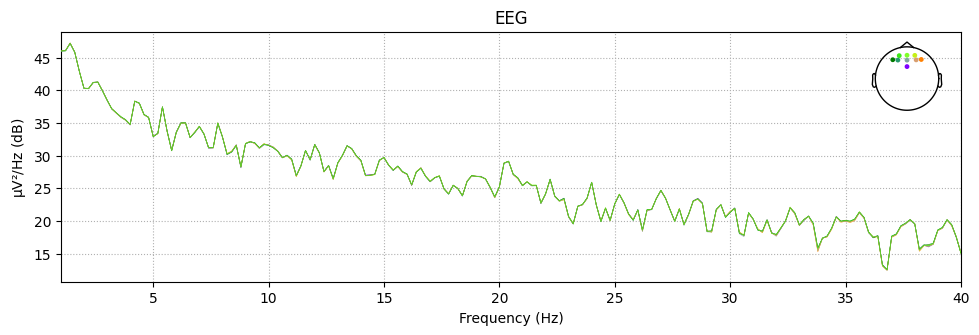

In [7]:
raws[0].compute_psd(n_fft=5*fs, fmin=1, fmax=40).plot()